# FAIDM Group Project: Student Performance Prediction & Clustering
## Open University Learning Analytics Dataset (OULAD)

**Module:** WM9QG-15 Fundamentals of AI and Data Mining  
**Methodology:** CRISP-DM  
**Deadline:** W/C 26th January 2026  

---

### Project Tasks:
1. **Predictive Model (Supervised ML):** Predict students' final outcomes based on demographics, VLE engagement, and assessment data
2. **Clustering Model (Unsupervised ML):** Segment students into meaningful groups based on engagement patterns

---

## 1. Business Understanding (CRISP-DM Phase 1)

### 1.1 Problem Statement
The Open University wants to:
- **Identify at-risk students early** for intervention
- **Understand student engagement patterns** to inform teaching strategies
- **Predict final module outcomes** to enable personalised support

### 1.2 Success Criteria
- Build a predictive model with acceptable accuracy (target: >70% or meaningful AUC-ROC)
- Identify actionable student segments that can inform intervention strategies
- Deliverables must follow CRISP-DM methodology and be presentation-ready

### 1.3 Business Questions
1. Which students are at risk of failing or withdrawing?
2. What engagement patterns characterise successful vs struggling students?
3. Can we intervene early enough to make a difference?

## 2. Data Understanding (CRISP-DM Phase 2)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Define data path - UPDATE THIS TO YOUR LOCAL PATH
DATA_PATH = Path('.')  # Change to your data directory

# Load all datasets
print("Loading datasets...\n")

student_info = pd.read_csv(DATA_PATH / 'studentInfo.csv')
student_assessment = pd.read_csv(DATA_PATH / 'studentAssessment.csv')
assessments = pd.read_csv(DATA_PATH / 'assessments.csv')
courses = pd.read_csv(DATA_PATH / 'courses.csv')
student_registration = pd.read_csv(DATA_PATH / 'studentRegistration.csv')
vle = pd.read_csv(DATA_PATH / 'vle.csv')
student_vle = pd.read_csv(DATA_PATH / 'studentVle.csv')

print("All datasets loaded successfully!")
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

Loading datasets...

All datasets loaded successfully!

DATASET OVERVIEW


In [3]:
# Display shape and basic info for each dataset
datasets = {
    'studentInfo': student_info,
    'studentAssessment': student_assessment,
    'assessments': assessments,
    'courses': courses,
    'studentRegistration': student_registration,
    'vle': vle,
    'studentVle': student_vle
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print(f"  Columns: {list(df.columns)}")


studentInfo:
  Shape: 32,593 rows x 12 columns
  Columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']

studentAssessment:
  Shape: 173,912 rows x 5 columns
  Columns: ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']

assessments:
  Shape: 206 rows x 6 columns
  Columns: ['code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'weight']

courses:
  Shape: 22 rows x 3 columns
  Columns: ['code_module', 'code_presentation', 'module_presentation_length']

studentRegistration:
  Shape: 32,593 rows x 5 columns
  Columns: ['code_module', 'code_presentation', 'id_student', 'date_registration', 'date_unregistration']

vle:
  Shape: 6,364 rows x 6 columns
  Columns: ['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to']

studentVle:
  Shape: 10,655,280 rows x 6 columns
  C

In [4]:
# Detailed look at studentInfo
print("="*60)
print("STUDENT INFO - DETAILED ANALYSIS")
print("="*60)
print(f"\nTotal student-module registrations: {len(student_info):,}")
print(f"Unique students: {student_info['id_student'].nunique():,}")
print(f"Unique modules: {student_info['code_module'].nunique()}")
print(f"Unique presentations: {student_info['code_presentation'].nunique()}")

print("\n--- Data Types ---")
print(student_info.dtypes)

STUDENT INFO - DETAILED ANALYSIS

Total student-module registrations: 32,593
Unique students: 28,785
Unique modules: 7
Unique presentations: 4

--- Data Types ---
code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object


In [5]:
# Missing values analysis
print("="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)

for name, df in datasets.items():
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    if missing.any():
        print(f"\n{name}:")
        for col in missing[missing > 0].index:
            print(f"  {col}: {missing[col]:,} ({missing_pct[col]}%)")
    else:
        print(f"\n{name}: No missing values")

MISSING VALUE ANALYSIS

studentInfo:
  imd_band: 1,111 (3.41%)

studentAssessment:
  score: 173 (0.1%)

assessments:
  date: 11 (5.34%)

courses: No missing values

studentRegistration:
  date_registration: 45 (0.14%)
  date_unregistration: 22,521 (69.1%)

vle:
  week_from: 5,243 (82.39%)
  week_to: 5,243 (82.39%)

studentVle: No missing values


TARGET VARIABLE: final_result

Distribution:
  Pass: 12,361 (37.9%)
  Withdrawn: 10,156 (31.2%)
  Fail: 7,052 (21.6%)
  Distinction: 3,024 (9.3%)


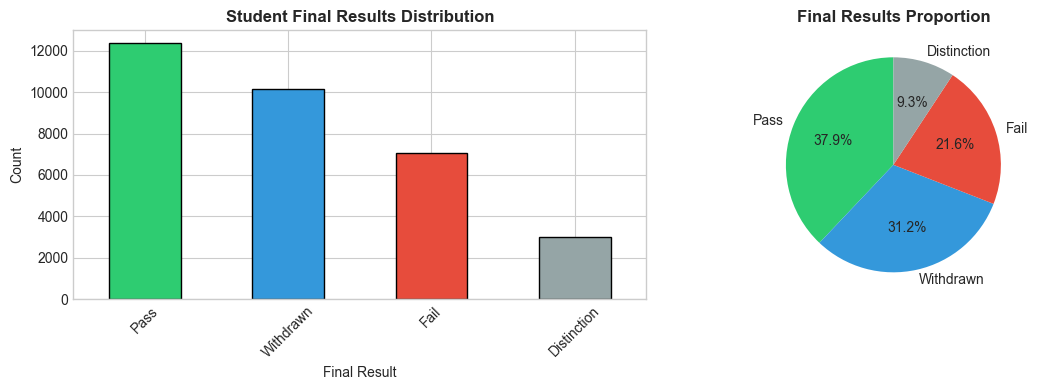


Note: Class imbalance present - consider stratified sampling


In [6]:
# Target variable analysis
print("="*60)
print("TARGET VARIABLE: final_result")
print("="*60)

result_counts = student_info['final_result'].value_counts()
result_pct = student_info['final_result'].value_counts(normalize=True) * 100

print("\nDistribution:")
for result in result_counts.index:
    print(f"  {result}: {result_counts[result]:,} ({result_pct[result]:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
result_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Student Final Results Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Final Result')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Final Results Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNote: Class imbalance present - consider stratified sampling")

In [7]:
# Categorical variables exploration
print("="*60)
print("CATEGORICAL VARIABLES")
print("="*60)

categorical_cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']

for col in categorical_cols:
    print(f"\n{col}:")
    print(student_info[col].value_counts())

CATEGORICAL VARIABLES

gender:
gender
M    17875
F    14718
Name: count, dtype: int64

region:
region
Scotland                3446
East Anglian Region     3340
London Region           3216
South Region            3092
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2086
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: count, dtype: int64

highest_education:
highest_education
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: count, dtype: int64

imd_band:
imd_band
20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: count, dtype: int64

age_band:
age_band
0-35     22944
35-55

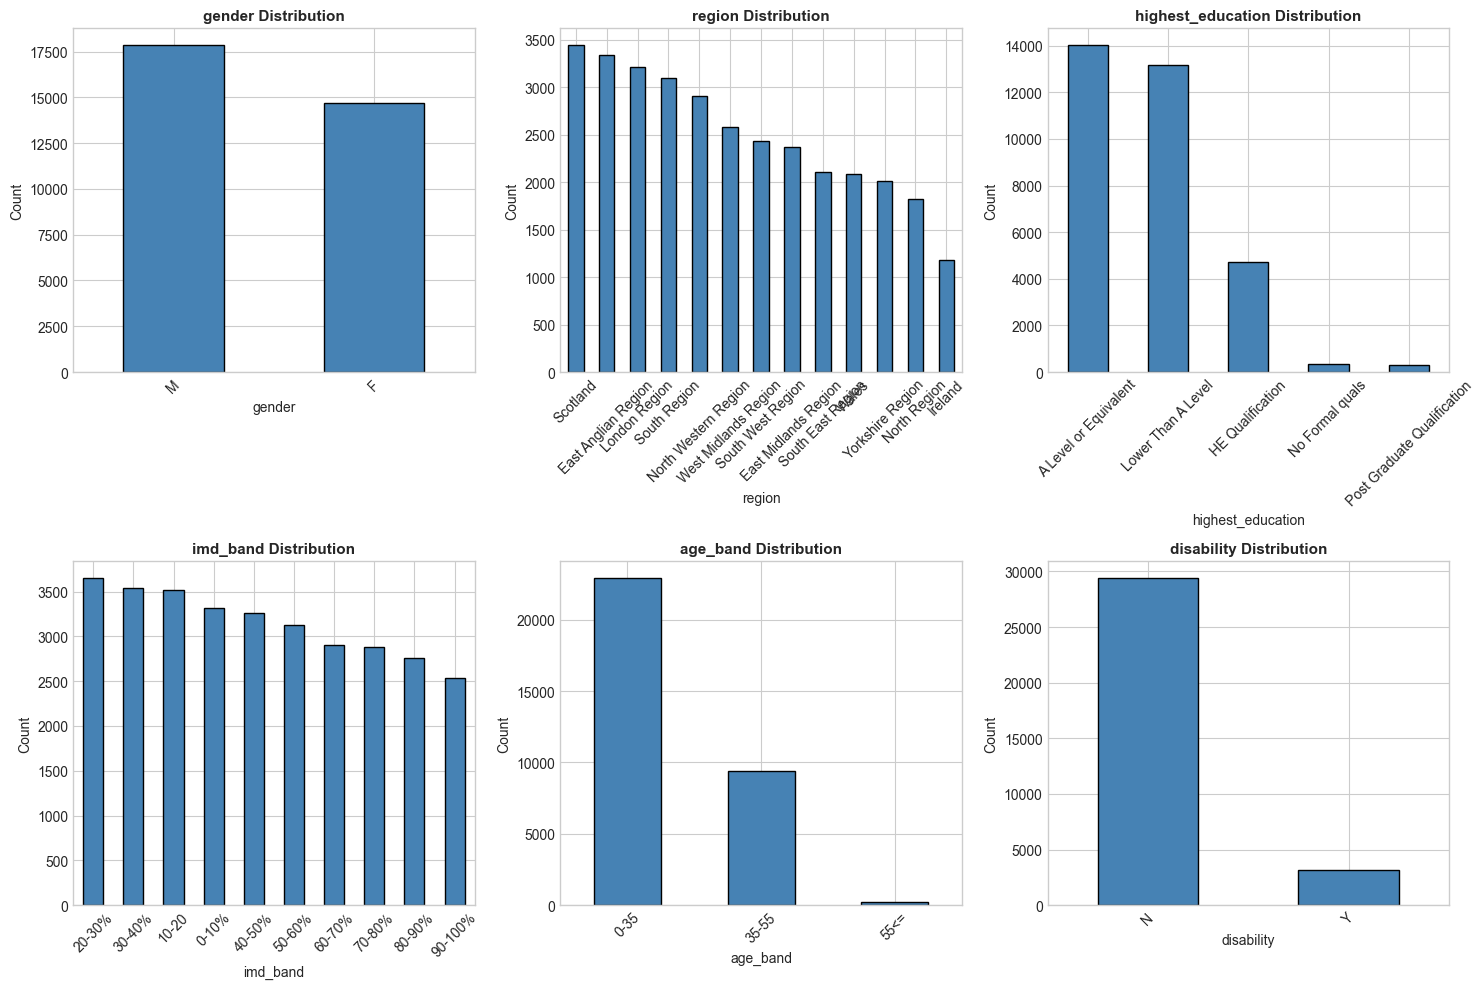

In [8]:
# Visualize demographics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    student_info[col].value_counts().plot(kind='bar', ax=axes[i], color='steelblue', edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

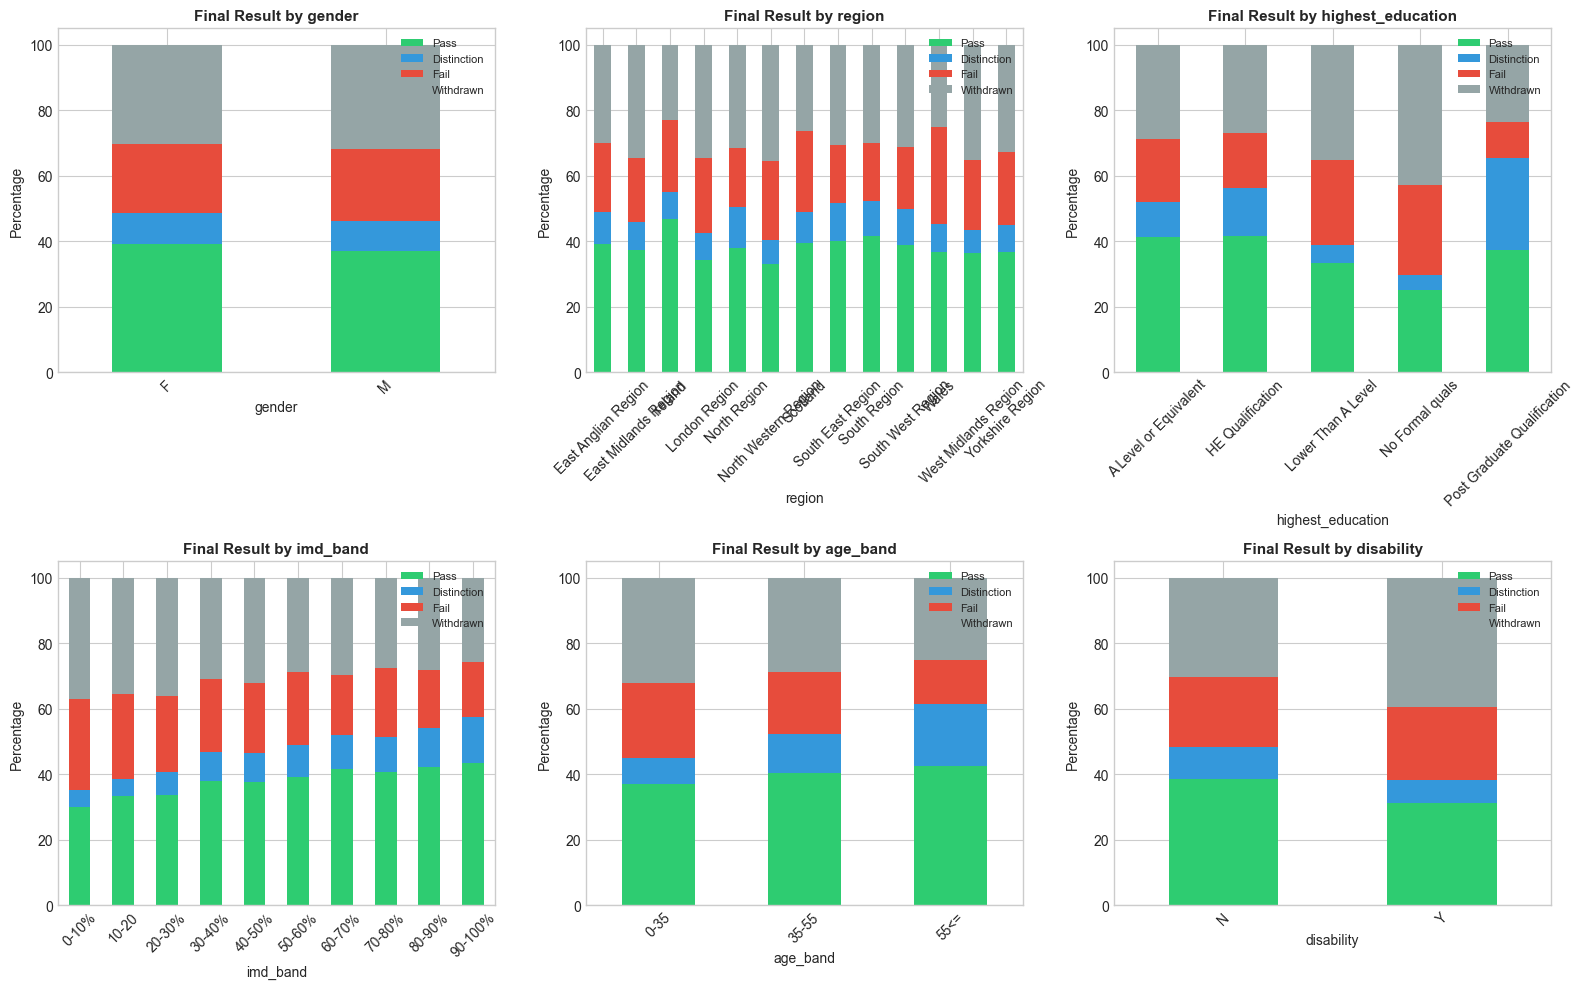

In [9]:
# Final result by demographics
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ct = pd.crosstab(student_info[col], student_info['final_result'], normalize='index') * 100
    ct[['Pass', 'Distinction', 'Fail', 'Withdrawn']].plot(kind='bar', stacked=True, ax=axes[i],
                                                          color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
    axes[i].set_title(f'Final Result by {col}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Percentage')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
# VLE Engagement Analysis
print("="*60)
print("VLE ENGAGEMENT ANALYSIS")
print("="*60)

print(f"\nTotal VLE interaction records: {len(student_vle):,}")
print(f"Total clicks recorded: {student_vle['sum_click'].sum():,}")
print(f"Unique students with VLE activity: {student_vle['id_student'].nunique():,}")
print(f"Date range: {student_vle['date'].min()} to {student_vle['date'].max()}")
print("  (negative = before course start)")

print("\n--- Click Statistics ---")
print(student_vle['sum_click'].describe())

VLE ENGAGEMENT ANALYSIS

Total VLE interaction records: 10,655,280
Total clicks recorded: 39,605,099
Unique students with VLE activity: 26,074
Date range: -25 to 269
  (negative = before course start)

--- Click Statistics ---
count    1.065528e+07
mean     3.716946e+00
std      8.849047e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      6.977000e+03
Name: sum_click, dtype: float64


In [11]:
# VLE Activity Types
print("\n--- VLE Activity Types ---")
print(vle['activity_type'].value_counts())

# Clicks by activity type
vle_with_type = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')
clicks_by_type = vle_with_type.groupby('activity_type')['sum_click'].sum().sort_values(ascending=False)

print("\n--- Total Clicks by Activity Type ---")
print(clicks_by_type)


--- VLE Activity Types ---
activity_type
resource          2660
subpage           1055
oucontent          996
url                886
forumng            194
quiz               127
page               102
oucollaborate       82
questionnaire       61
ouwiki              49
dataplus            28
externalquiz        26
homepage            22
glossary            21
ouelluminate        21
dualpane            20
repeatactivity       5
htmlactivity         4
sharedsubpage        3
folder               2
Name: count, dtype: int64

--- Total Clicks by Activity Type ---
activity_type
oucontent         11206803
forumng            7973390
quiz               6981240
homepage           6949064
subpage            3411582
resource           1110132
ouwiki              894512
url                 566702
oucollaborate       108974
glossary             87962
questionnaire        64764
externalquiz         64292
page                 63631
dataplus             47468
ouelluminate         39028
dualpane      

In [12]:
# Assessment analysis
print("="*60)
print("ASSESSMENT DATA ANALYSIS")
print("="*60)

print(f"\nTotal assessments in catalog: {len(assessments)}")
print(f"Total submissions: {len(student_assessment):,}")

print("\nAssessment types:")
print(assessments['assessment_type'].value_counts())

print("\n--- Score Statistics ---")
print(student_assessment['score'].describe())

missing_scores = student_assessment['score'].isnull().sum()
print(f"\nMissing scores: {missing_scores:,} ({missing_scores/len(student_assessment)*100:.2f}%)")

ASSESSMENT DATA ANALYSIS

Total assessments in catalog: 206
Total submissions: 173,912

Assessment types:
assessment_type
TMA     106
CMA      76
Exam     24
Name: count, dtype: int64

--- Score Statistics ---
count    173739.000000
mean         75.799573
std          18.798107
min           0.000000
25%          65.000000
50%          80.000000
75%          90.000000
max         100.000000
Name: score, dtype: float64

Missing scores: 173 (0.10%)


## 3. Data Preparation (CRISP-DM Phase 3)

In [13]:
# Build unified dataset
print("="*60)
print("BUILDING UNIFIED DATASET")
print("="*60)

df = student_info.copy()

# Create unique key
df['student_module_key'] = (df['id_student'].astype(str) + '_' + 
                            df['code_module'] + '_' + df['code_presentation'])

print(f"Base dataset: {df.shape}")

BUILDING UNIFIED DATASET
Base dataset: (32593, 13)


In [14]:
# Merge course info
df = df.merge(courses, on=['code_module', 'code_presentation'], how='left')
print(f"After courses: {df.shape}")

After courses: (32593, 14)


In [15]:
# Merge registration and create features
df = df.merge(student_registration, on=['code_module', 'code_presentation', 'id_student'], how='left')
print(f"After registration: {df.shape}")

df['registered_early'] = (df['date_registration'] < 0).astype(int)
df['days_before_start'] = df['date_registration'].apply(lambda x: abs(x) if x < 0 else 0)
df['withdrew'] = df['date_unregistration'].notna().astype(int)

After registration: (32593, 16)


In [16]:
# Assessment features
print("\n--- Creating Assessment Features ---")

assessments_with_meta = student_assessment.merge(assessments, on='id_assessment', how='left')
assessments_with_meta['student_module_key'] = (assessments_with_meta['id_student'].astype(str) + '_' + 
                                                assessments_with_meta['code_module'] + '_' + 
                                                assessments_with_meta['code_presentation'])

# Aggregate
assessment_features = assessments_with_meta.groupby('student_module_key').agg({
    'score': ['mean', 'std', 'min', 'max', 'count'],
    'date_submitted': ['mean', 'std'],
    'is_banked': 'sum'
}).reset_index()

assessment_features.columns = ['student_module_key', 'avg_score', 'score_std', 'min_score', 'max_score', 
                               'num_assessments_submitted', 'avg_submission_day', 'submission_day_std', 
                               'num_banked']

# Timeliness
assessments_with_meta['days_early'] = assessments_with_meta['date'] - assessments_with_meta['date_submitted']
timeliness = assessments_with_meta.groupby('student_module_key').agg({
    'days_early': ['mean', 'min']
}).reset_index()
timeliness.columns = ['student_module_key', 'avg_days_early', 'worst_days_early']

assessment_features = assessment_features.merge(timeliness, on='student_module_key', how='left')

print(f"Assessment features: {assessment_features.shape}")


--- Creating Assessment Features ---
Assessment features: (25843, 11)


In [17]:
# Merge assessment features
df = df.merge(assessment_features, on='student_module_key', how='left')
print(f"After assessments: {df.shape}")

After assessments: (32593, 29)


In [18]:
# Assessment type-specific features
print("\n--- Assessment Type Features ---")

for atype in ['TMA', 'CMA', 'Exam']:
    type_data = assessments_with_meta[assessments_with_meta['assessment_type'] == atype]
    type_scores = type_data.groupby('student_module_key').agg({'score': ['mean', 'count']}).reset_index()
    type_scores.columns = ['student_module_key', f'{atype.lower()}_avg_score', f'{atype.lower()}_count']
    df = df.merge(type_scores, on='student_module_key', how='left')
    print(f"  Added {atype} features")

print(f"After assessment types: {df.shape}")


--- Assessment Type Features ---
  Added TMA features
  Added CMA features
  Added Exam features
After assessment types: (32593, 35)


In [19]:
# VLE Engagement Features
print("\n" + "="*60)
print("CREATING VLE ENGAGEMENT FEATURES")
print("="*60)

student_vle['student_module_key'] = (student_vle['id_student'].astype(str) + '_' + 
                                      student_vle['code_module'] + '_' + 
                                      student_vle['code_presentation'])

# Basic engagement
vle_features = student_vle.groupby('student_module_key').agg({
    'sum_click': ['sum', 'mean', 'std', 'max'],
    'date': ['min', 'max', 'nunique'],
    'id_site': 'nunique'
}).reset_index()

vle_features.columns = ['student_module_key', 'total_clicks', 'avg_daily_clicks', 
                        'click_std', 'max_daily_clicks', 'first_access_day', 
                        'last_access_day', 'active_days', 'unique_resources']

vle_features['engagement_span'] = vle_features['last_access_day'] - vle_features['first_access_day']
vle_features['clicks_per_active_day'] = vle_features['total_clicks'] / vle_features['active_days'].replace(0, 1)

print(f"VLE features: {vle_features.shape}")


CREATING VLE ENGAGEMENT FEATURES
VLE features: (29228, 11)


In [20]:
# Activity type clicks
print("\n--- Activity Type Click Features ---")

vle_with_type = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')
activity_clicks = vle_with_type.groupby(['student_module_key', 'activity_type'])['sum_click'].sum().unstack(fill_value=0)
activity_clicks = activity_clicks.add_prefix('clicks_').reset_index()

print(f"Activity types: {activity_clicks.shape[1] - 1}")

vle_features = vle_features.merge(activity_clicks, on='student_module_key', how='left')


--- Activity Type Click Features ---
Activity types: 20


In [21]:
# Early engagement (first 2 weeks)
print("\n--- Early Engagement Features ---")

early_vle = student_vle[student_vle['date'] <= 14]
early_engagement = early_vle.groupby('student_module_key').agg({
    'sum_click': 'sum',
    'date': 'nunique',
    'id_site': 'nunique'
}).reset_index()
early_engagement.columns = ['student_module_key', 'early_clicks', 'early_active_days', 'early_resources']

vle_features = vle_features.merge(early_engagement, on='student_module_key', how='left')

# Pre-course engagement
pre_course = student_vle[student_vle['date'] < 0]
pre_engagement = pre_course.groupby('student_module_key')['sum_click'].sum().reset_index()
pre_engagement.columns = ['student_module_key', 'pre_course_clicks']

vle_features = vle_features.merge(pre_engagement, on='student_module_key', how='left')

print(f"Final VLE features: {vle_features.shape}")


--- Early Engagement Features ---
Final VLE features: (29228, 35)


In [22]:
# Merge VLE features
df = df.merge(vle_features, on='student_module_key', how='left')
print(f"After VLE features: {df.shape}")

After VLE features: (32593, 69)


In [23]:
# Data cleaning
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

df['imd_band'] = df['imd_band'].fillna('Unknown')

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

print(f"Missing values after cleaning: {df.isnull().sum().sum()}")


DATA CLEANING
Missing values after cleaning: 0


In [25]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

print("\n--- Encoding Categorical Variables ---")

df_encoded = df.copy()
label_encoders = {}

for col in ['gender', 'region', 'disability', 'code_module', 'code_presentation']:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"  Encoded {col}: {len(le.classes_)} categories")

# Ordinal encode education and age
education_order = ['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 
                   'HE Qualification', 'Post Graduate Qualification']
df_encoded['education_level'] = df_encoded['highest_education'].apply(
    lambda x: education_order.index(x) if x in education_order else -1)

age_order = ['0-35', '35-55', '55<=']
df_encoded['age_level'] = df_encoded['age_band'].apply(
    lambda x: age_order.index(x) if x in age_order else -1)


--- Encoding Categorical Variables ---
  Encoded gender: 2 categories
  Encoded region: 13 categories
  Encoded disability: 2 categories
  Encoded code_module: 7 categories
  Encoded code_presentation: 4 categories


In [26]:
# Create target variables
print("\n--- Target Variables ---")

df_encoded['target_binary'] = df_encoded['final_result'].apply(
    lambda x: 1 if x in ['Pass', 'Distinction'] else 0)

result_mapping = {'Pass': 2, 'Distinction': 3, 'Fail': 1, 'Withdrawn': 0}
df_encoded['target_multiclass'] = df_encoded['final_result'].map(result_mapping)

print("\nBinary (1=Pass/Distinction, 0=Fail/Withdrawn):")
print(df_encoded['target_binary'].value_counts())


--- Target Variables ---

Binary (1=Pass/Distinction, 0=Fail/Withdrawn):
target_binary
0    17208
1    15385
Name: count, dtype: int64


In [27]:
# Final dataset
print("\n" + "="*60)
print("FINAL PREPARED DATASET")
print("="*60)
print(f"\nShape: {df_encoded.shape}")
print(f"\nColumns: {len(df_encoded.columns)}")


FINAL PREPARED DATASET

Shape: (32593, 78)

Columns: 78


In [28]:
# Save
df_encoded.to_csv('prepared_student_data.csv', index=False)
print("Saved to 'prepared_student_data.csv'")

Saved to 'prepared_student_data.csv'


## 4. Modelling (CRISP-DM Phase 4)

### 4.1 Predictive Model

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

print("ML libraries loaded!")

ML libraries loaded!


In [30]:
# Select features
exclude_cols = ['id_student', 'student_module_key', 'final_result', 'target_binary', 
                'target_multiclass', 'code_module', 'code_presentation', 'gender', 
                'region', 'highest_education', 'imd_band', 'age_band', 'disability',
                'date_registration', 'date_unregistration']

feature_cols = [col for col in df_encoded.columns if col not in exclude_cols 
               and df_encoded[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Features: {len(feature_cols)}")
print(feature_cols)

Features: 63
['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'registered_early', 'days_before_start', 'withdrew', 'avg_score', 'score_std', 'min_score', 'max_score', 'num_assessments_submitted', 'avg_submission_day', 'submission_day_std', 'num_banked', 'avg_days_early', 'worst_days_early', 'tma_avg_score', 'tma_count', 'cma_avg_score', 'cma_count', 'exam_avg_score', 'exam_count', 'total_clicks', 'avg_daily_clicks', 'click_std', 'max_daily_clicks', 'first_access_day', 'last_access_day', 'active_days', 'unique_resources', 'engagement_span', 'clicks_per_active_day', 'clicks_dataplus', 'clicks_dualpane', 'clicks_externalquiz', 'clicks_folder', 'clicks_forumng', 'clicks_glossary', 'clicks_homepage', 'clicks_htmlactivity', 'clicks_oucollaborate', 'clicks_oucontent', 'clicks_ouelluminate', 'clicks_ouwiki', 'clicks_page', 'clicks_questionnaire', 'clicks_quiz', 'clicks_repeatactivity', 'clicks_resource', 'clicks_sharedsubpage', 'clicks_subpage', 'clicks_url', 'early_cl

In [31]:
# Prepare data
X = df_encoded[feature_cols].copy()
y = df_encoded['target_binary'].copy()

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

Train: 26,074
Test: 6,519


In [32]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Train models
print("="*60)
print("MODEL TRAINING")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }
    
    for metric, value in results[name].items():
        print(f"  {metric}: {value:.4f}")

MODEL TRAINING

--- Logistic Regression ---
  Accuracy: 0.9508
  Precision: 0.9264
  Recall: 0.9730
  F1: 0.9491
  AUC-ROC: 0.9876

--- Random Forest ---
  Accuracy: 0.9564
  Precision: 0.9328
  Recall: 0.9782
  F1: 0.9549
  AUC-ROC: 0.9888

--- Gradient Boosting ---
  Accuracy: 0.9569
  Precision: 0.9336
  Recall: 0.9782
  F1: 0.9554
  AUC-ROC: 0.9901



MODEL COMPARISON
                     Accuracy  Precision  Recall      F1  AUC-ROC
Logistic Regression    0.9508     0.9264  0.9730  0.9491   0.9876
Random Forest          0.9564     0.9328  0.9782  0.9549   0.9888
Gradient Boosting      0.9569     0.9336  0.9782  0.9554   0.9901


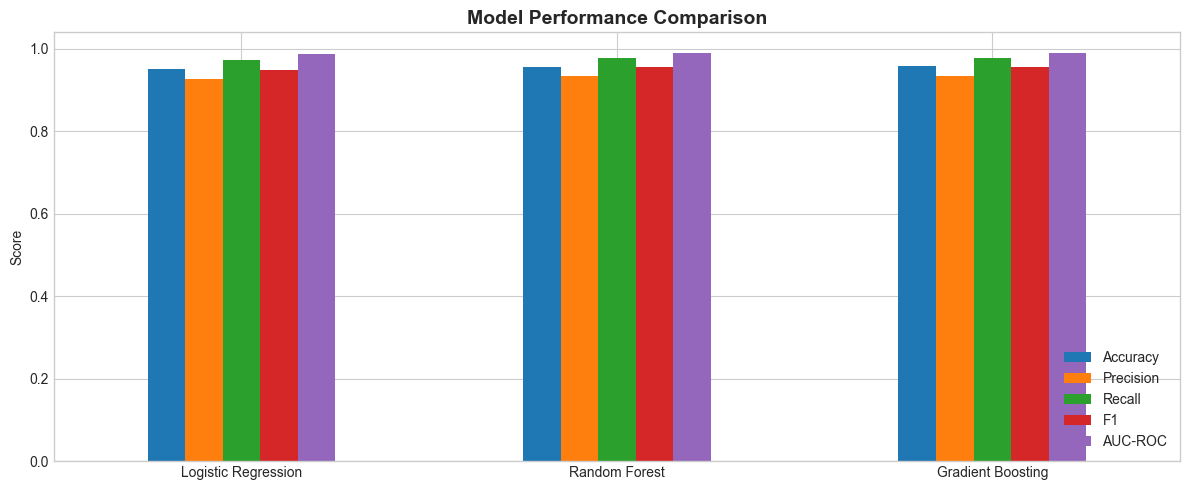

In [34]:
# Results comparison
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.round(4))

results_df.plot(kind='bar', figsize=(12, 5))
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

RANDOM FOREST - DETAILED

Classification Report:
                  precision    recall  f1-score   support

  Fail/Withdrawn       0.98      0.94      0.96      3442
Pass/Distinction       0.93      0.98      0.95      3077

        accuracy                           0.96      6519
       macro avg       0.96      0.96      0.96      6519
    weighted avg       0.96      0.96      0.96      6519



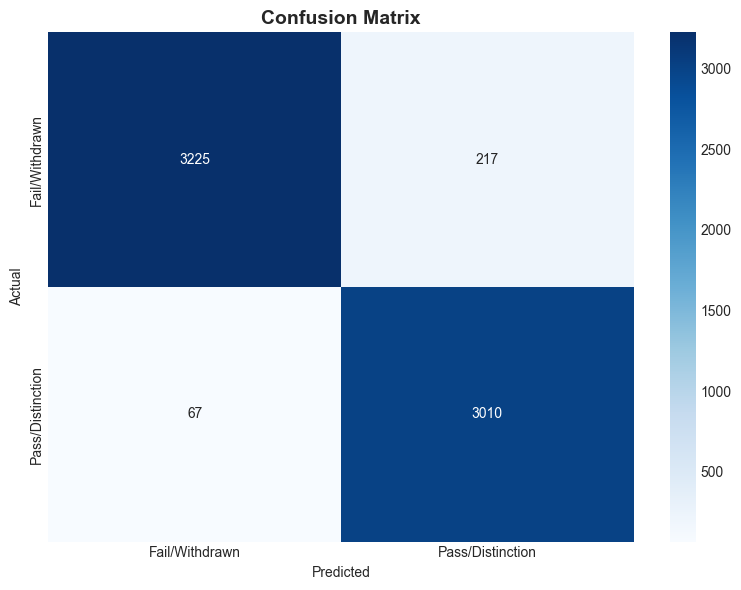

In [35]:
# Random Forest Analysis
print("="*60)
print("RANDOM FOREST - DETAILED")
print("="*60)

rf_model = models['Random Forest']
y_pred_rf = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Fail/Withdrawn', 'Pass/Distinction']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fail/Withdrawn', 'Pass/Distinction'],
            yticklabels=['Fail/Withdrawn', 'Pass/Distinction'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Top 20 Features:
                  feature  importance
          last_access_day    0.138665
       avg_submission_day    0.117576
       submission_day_std    0.090436
          engagement_span    0.087082
              active_days    0.057584
                tma_count    0.057032
num_assessments_submitted    0.051295
                 withdrew    0.034767
                avg_score    0.031518
                score_std    0.028532
            tma_avg_score    0.026706
                max_score    0.025550
          clicks_homepage    0.020217
           exam_avg_score    0.017748
             total_clicks    0.016914
                cma_count    0.016275
                min_score    0.015734
           clicks_forumng    0.014314
              clicks_quiz    0.012740
         unique_resources    0.008367


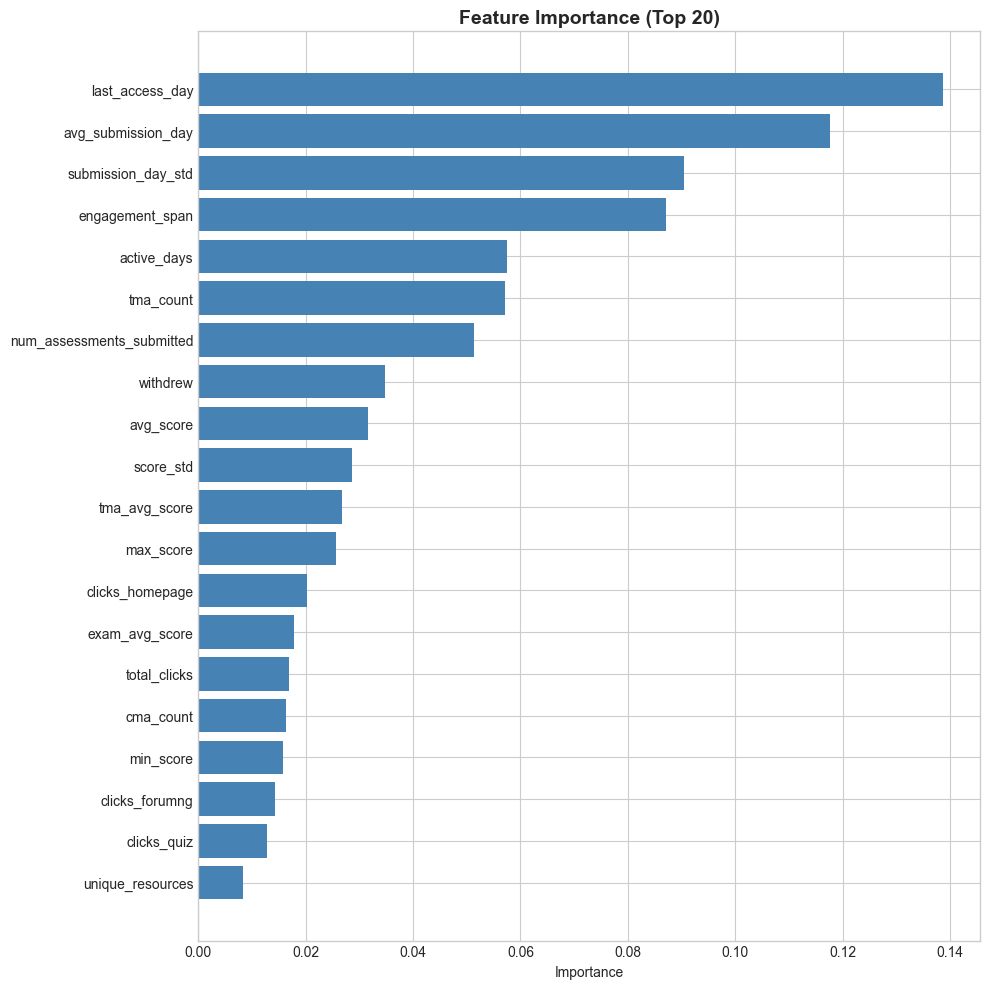

In [36]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features:")
print(feature_importance.head(20).to_string(index=False))

plt.figure(figsize=(10, 10))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

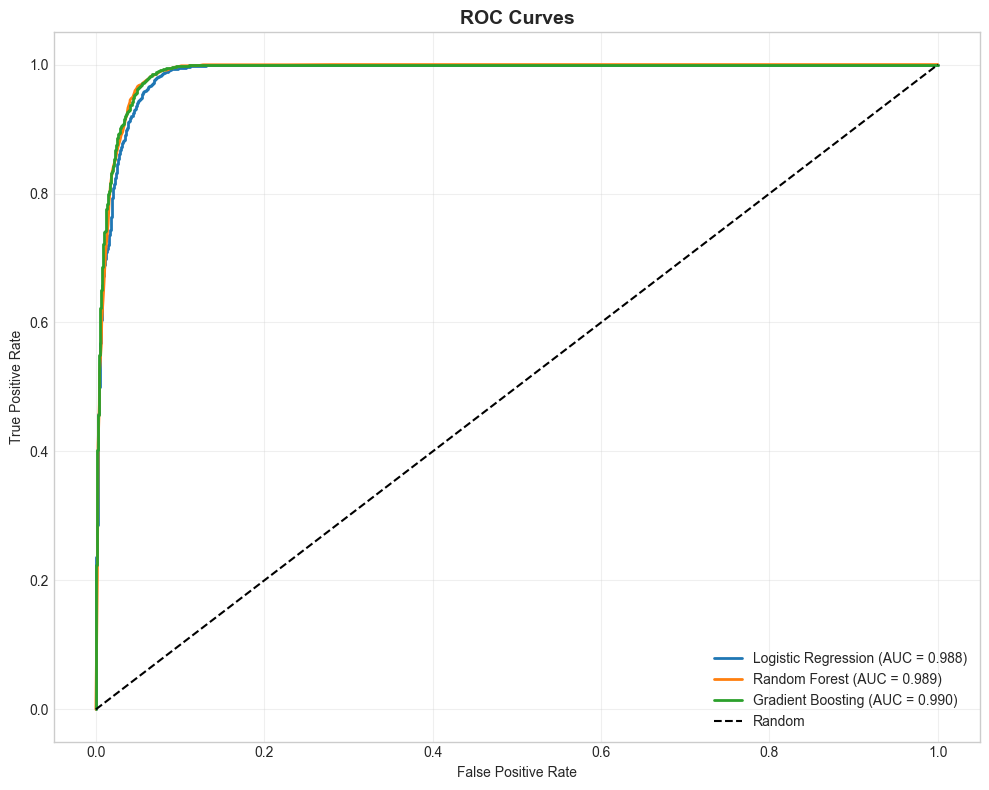

In [37]:
# ROC Curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if 'Logistic' in name:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# Hyperparameter tuning
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_tuned, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest params: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

print(f"\nTuned Test Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Tuned Test AUC-ROC: {roc_auc_score(y_test, y_proba_tuned):.4f}")

HYPERPARAMETER TUNING
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV AUC: 0.9880

Tuned Test Accuracy: 0.9575
Tuned Test AUC-ROC: 0.9890


### 4.2 Clustering Model

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [40]:
# Clustering features (engagement-focused)
clustering_features = [
    'total_clicks', 'avg_daily_clicks', 'active_days', 'unique_resources',
    'early_clicks', 'early_active_days', 'early_resources', 'pre_course_clicks',
    'avg_score', 'num_assessments_submitted', 'avg_days_early',
    'clicks_per_active_day', 'engagement_span'
]

clustering_features = [f for f in clustering_features if f in df_encoded.columns]
print(f"Clustering features: {len(clustering_features)}")

Clustering features: 13


In [41]:
# Prepare
X_cluster = df_encoded[clustering_features].copy()
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

print(f"Clustering data: {X_cluster_scaled.shape}")

Clustering data: (32593, 13)


In [42]:
# Find optimal k
print("="*60)
print("FINDING OPTIMAL K")
print("="*60)

K_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_cluster_scaled, kmeans.labels_))
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, DB={davies_bouldin_scores[-1]:.4f}")

FINDING OPTIMAL K
k=2: Silhouette=0.3367, DB=1.2562
k=3: Silhouette=0.3199, DB=1.1812
k=4: Silhouette=0.2901, DB=1.3653
k=5: Silhouette=0.2679, DB=1.4191
k=6: Silhouette=0.2682, DB=1.4489
k=7: Silhouette=0.2639, DB=1.4327
k=8: Silhouette=0.2720, DB=1.3739
k=9: Silhouette=0.2535, DB=1.4057
k=10: Silhouette=0.2557, DB=1.4078


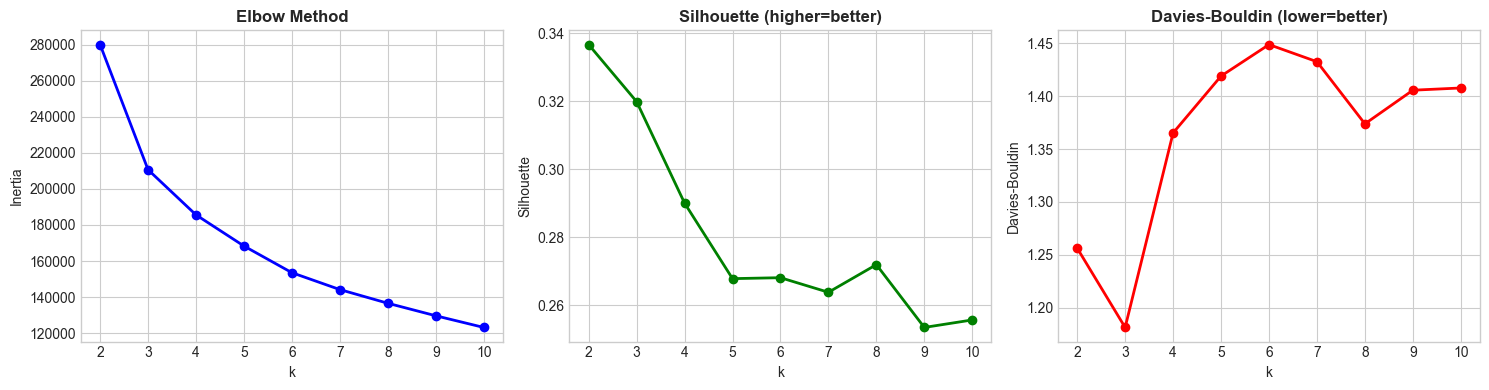

In [43]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2)
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')

axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2)
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette (higher=better)', fontsize=12, fontweight='bold')

axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2)
axes[2].set_xlabel('k')
axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Davies-Bouldin (lower=better)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [44]:
# Final K-Means
OPTIMAL_K = 3  # Adjust based on above

print(f"\nFitting K-Means with k={OPTIMAL_K}")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

df_encoded['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_encoded['cluster'].value_counts().sort_index())


Fitting K-Means with k=3

Cluster distribution:
cluster
0     9289
1    17835
2     5469
Name: count, dtype: int64


In [45]:
# Cluster profiling
print("="*60)
print("CLUSTER PROFILES")
print("="*60)

cluster_profiles = df_encoded.groupby('cluster')[clustering_features].mean()
print(cluster_profiles.round(2).T)

CLUSTER PROFILES
cluster                        0       1        2
total_clicks               66.68  965.90  3978.57
avg_daily_clicks            1.57    3.27     4.13
active_days                 5.20   56.50   137.54
unique_resources           10.17   59.82   146.13
early_clicks               32.68  142.95   611.13
early_active_days           2.53    7.78    18.66
early_resources             6.35   17.85    47.06
pre_course_clicks          12.52   42.87   231.69
avg_score                  14.74   73.25    79.63
num_assessments_submitted   0.50    6.57     9.51
avg_days_early              0.29    7.46    31.58
clicks_per_active_day       8.14   17.85    29.74
engagement_span            28.87  212.30   250.12


In [46]:
# Cluster vs outcome
print("\n--- Cluster vs Final Result ---")
cluster_outcome = pd.crosstab(df_encoded['cluster'], df_encoded['final_result'], normalize='index') * 100
print(cluster_outcome.round(1))

success_rate = df_encoded.groupby('cluster')['target_binary'].mean() * 100
print("\nSuccess Rate per Cluster:")
for c, rate in success_rate.items():
    print(f"  Cluster {c}: {rate:.1f}%")


--- Cluster vs Final Result ---
final_result  Distinction  Fail  Pass  Withdrawn
cluster                                         
0                     0.0  26.6   0.2       73.2
1                    10.2  22.9  50.3       16.5
2                    21.9   9.0  61.6        7.5

Success Rate per Cluster:
  Cluster 0: 0.2%
  Cluster 1: 60.5%
  Cluster 2: 83.5%


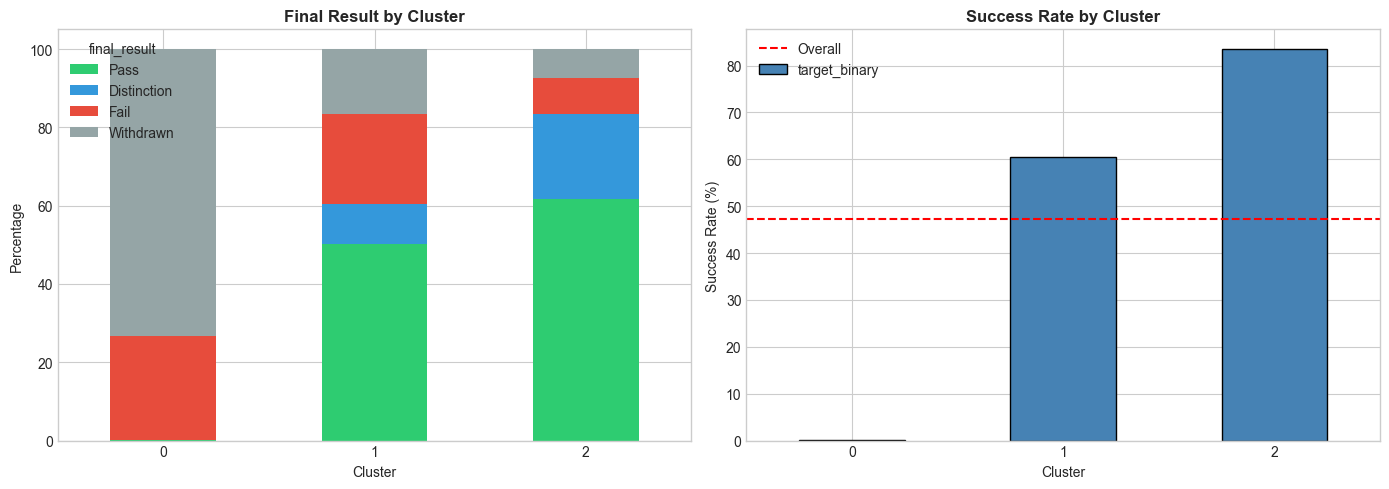

In [47]:
# Visualize cluster outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cluster_outcome[['Pass', 'Distinction', 'Fail', 'Withdrawn']].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=['#2ecc71', '#3498db', '#e74c3c', '#95a5a6'])
axes[0].set_title('Final Result by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=0)

success_rate.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Success Rate by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Success Rate (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].axhline(y=df_encoded['target_binary'].mean()*100, color='red', linestyle='--', label='Overall')
axes[1].legend()

plt.tight_layout()
plt.show()

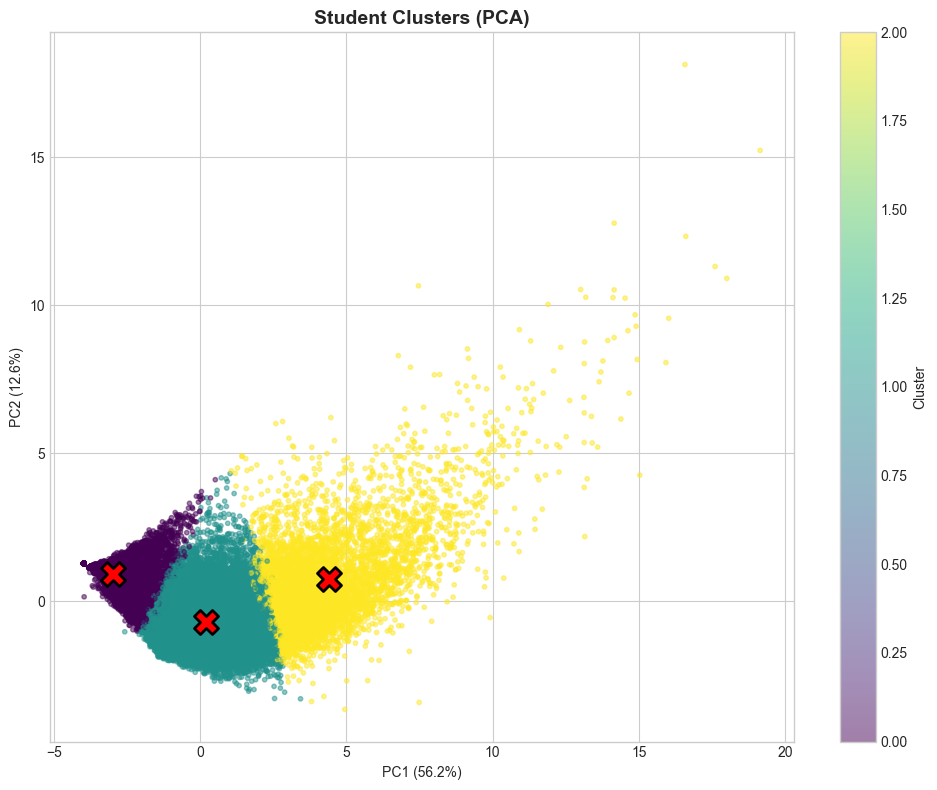

In [48]:
# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Student Clusters (PCA)', fontsize=14, fontweight='bold')

centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2)

plt.tight_layout()
plt.show()

## 5. Evaluation (CRISP-DM Phase 5)

In [50]:
print("="*60)
print("EVALUATION SUMMARY")
print("="*60)

print("\n--- PREDICTIVE MODEL ---")
print(f"Best: Gradient Boosting")
print(f"Test AUC-ROC: 9901")
print(f"\nTop 5 Features:")
for _, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\n--- CLUSTERING MODEL ---")
print(f"Clusters: {OPTIMAL_K}")
print(f"Silhouette: {silhouette_score(X_cluster_scaled, cluster_labels):.4f}")
print(f"\nCluster Success Rates:")
for c, rate in success_rate.items():
    print(f"  Cluster {c}: {rate:.1f}%")

EVALUATION SUMMARY

--- PREDICTIVE MODEL ---
Best: Gradient Boosting
Test AUC-ROC: 9901

Top 5 Features:
  last_access_day: 0.1387
  avg_submission_day: 0.1176
  submission_day_std: 0.0904
  engagement_span: 0.0871
  active_days: 0.0576

--- CLUSTERING MODEL ---
Clusters: 3
Silhouette: 0.3199

Cluster Success Rates:
  Cluster 0: 0.2%
  Cluster 1: 60.5%
  Cluster 2: 83.5%


## 6. Deployment Considerations (CRISP-DM Phase 6)

**Recommendations:**
1. Deploy Random Forest model for at-risk student identification
2. Run predictions weekly during term
3. Flag students with P(success) < 0.5 for intervention
4. Use cluster assignments for personalised support pathways

**Limitations:**
- Model trained on historical data
- Need validation on new presentations
- Consider temporal models for early prediction

---

**Questions for Amir:**
1. Can we use statistical methods (Pearson correlation) beyond module content?
2. Does everyone need to present?